In [1]:
import warnings, logging, os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange
tfds.disable_progress_bar()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.__version__, tf.keras.__version__, tf.test.is_gpu_available()

('2.8.0', '2.8.0', False)

___

# HAND SIGNS MNIST

The Sign Language MNIST is presented here

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar

___

### DATA GENERATORS

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# generators for iterating through images batcges
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory("data/sign-language-img/Train",
                                            target_size=(28, 28),
                                            batch_size=128,
                                            class_mode='categorical',
                                            color_mode='grayscale',
                                            subset='training')

validation_generator = test_datagen.flow_from_directory("data/sign-language-img/Test",
                                            target_size=(28, 28),
                                            batch_size=128,
                                            class_mode='categorical',
                                            color_mode='grayscale',
                                            subset='validation')

test_generator = test_datagen.flow_from_directory("data/sign-language-img/Test",
                                            target_size=(28, 28),
                                            batch_size=128,
                                            class_mode='categorical',
                                            color_mode='grayscale')

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [4]:
import string

# 24 classes since J and Z are not there
labels = [ char for char in string.ascii_uppercase if char != "J" if char != "Z" ]
labels[1:4]

['B', 'C', 'D']

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize = (10, 10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

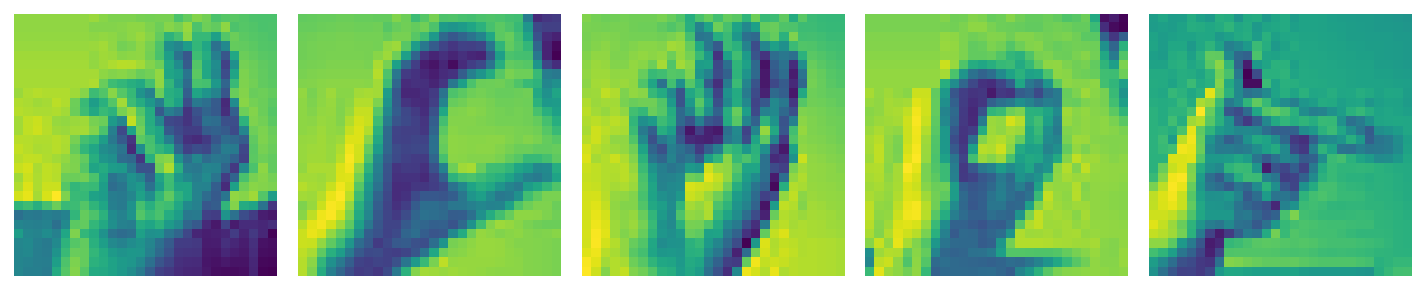

In [6]:
sample_training_images, _= next(train_generator)
plotImages(sample_training_images[:5])

___

### BASE NEURAL NETWORK

In [7]:
base_model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape= (28, 28, 1)),
            tf.keras.layers.Dense(256, activation = "relu"),
            tf.keras.layers.Dense(128, activation = "relu"),
            tf.keras.layers.Dense(len(labels), activation = "softmax")
])

In [8]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 236,952
Trainable params: 236,952
Non-trainable params: 0
_________________________________________________________________


In [9]:
base_model.compile(optimizer = "adam", loss = "categorical_crossentropy",
                metrics = ['accuracy'])


history = base_model.fit(
    train_generator, 
    epochs= 20, 
    validation_data = validation_generator
)

Epoch 1/20
215/215 [==============================] - 5s 22ms/step - loss: 2.2418 - accuracy: 0.3350 - val_loss: 1.7038 - val_accuracy: 0.4772
Epoch 2/20
215/215 [==============================] - 5s 21ms/step - loss: 1.2964 - accuracy: 0.5960 - val_loss: 1.3734 - val_accuracy: 0.5642
Epoch 3/20
215/215 [==============================] - 5s 21ms/step - loss: 0.9579 - accuracy: 0.7011 - val_loss: 1.1894 - val_accuracy: 0.6526
Epoch 4/20
215/215 [==============================] - 4s 21ms/step - loss: 0.7395 - accuracy: 0.7707 - val_loss: 1.1329 - val_accuracy: 0.6547
Epoch 5/20
215/215 [==============================] - 5s 21ms/step - loss: 0.5887 - accuracy: 0.8211 - val_loss: 1.0929 - val_accuracy: 0.6449
Epoch 6/20
215/215 [==============================] - 5s 21ms/step - loss: 0.4493 - accuracy: 0.8643 - val_loss: 1.0109 - val_accuracy: 0.7046
Epoch 7/20
215/215 [==============================] - 5s 21ms/step - loss: 0.3293 - accuracy: 0.9079 - val_loss: 0.9999 - val_accuracy: 0.7025

In [10]:
results = base_model.evaluate(test_generator)

57/57 [==============================] - 1s 23ms/step - loss: 1.1368 - accuracy: 0.7605


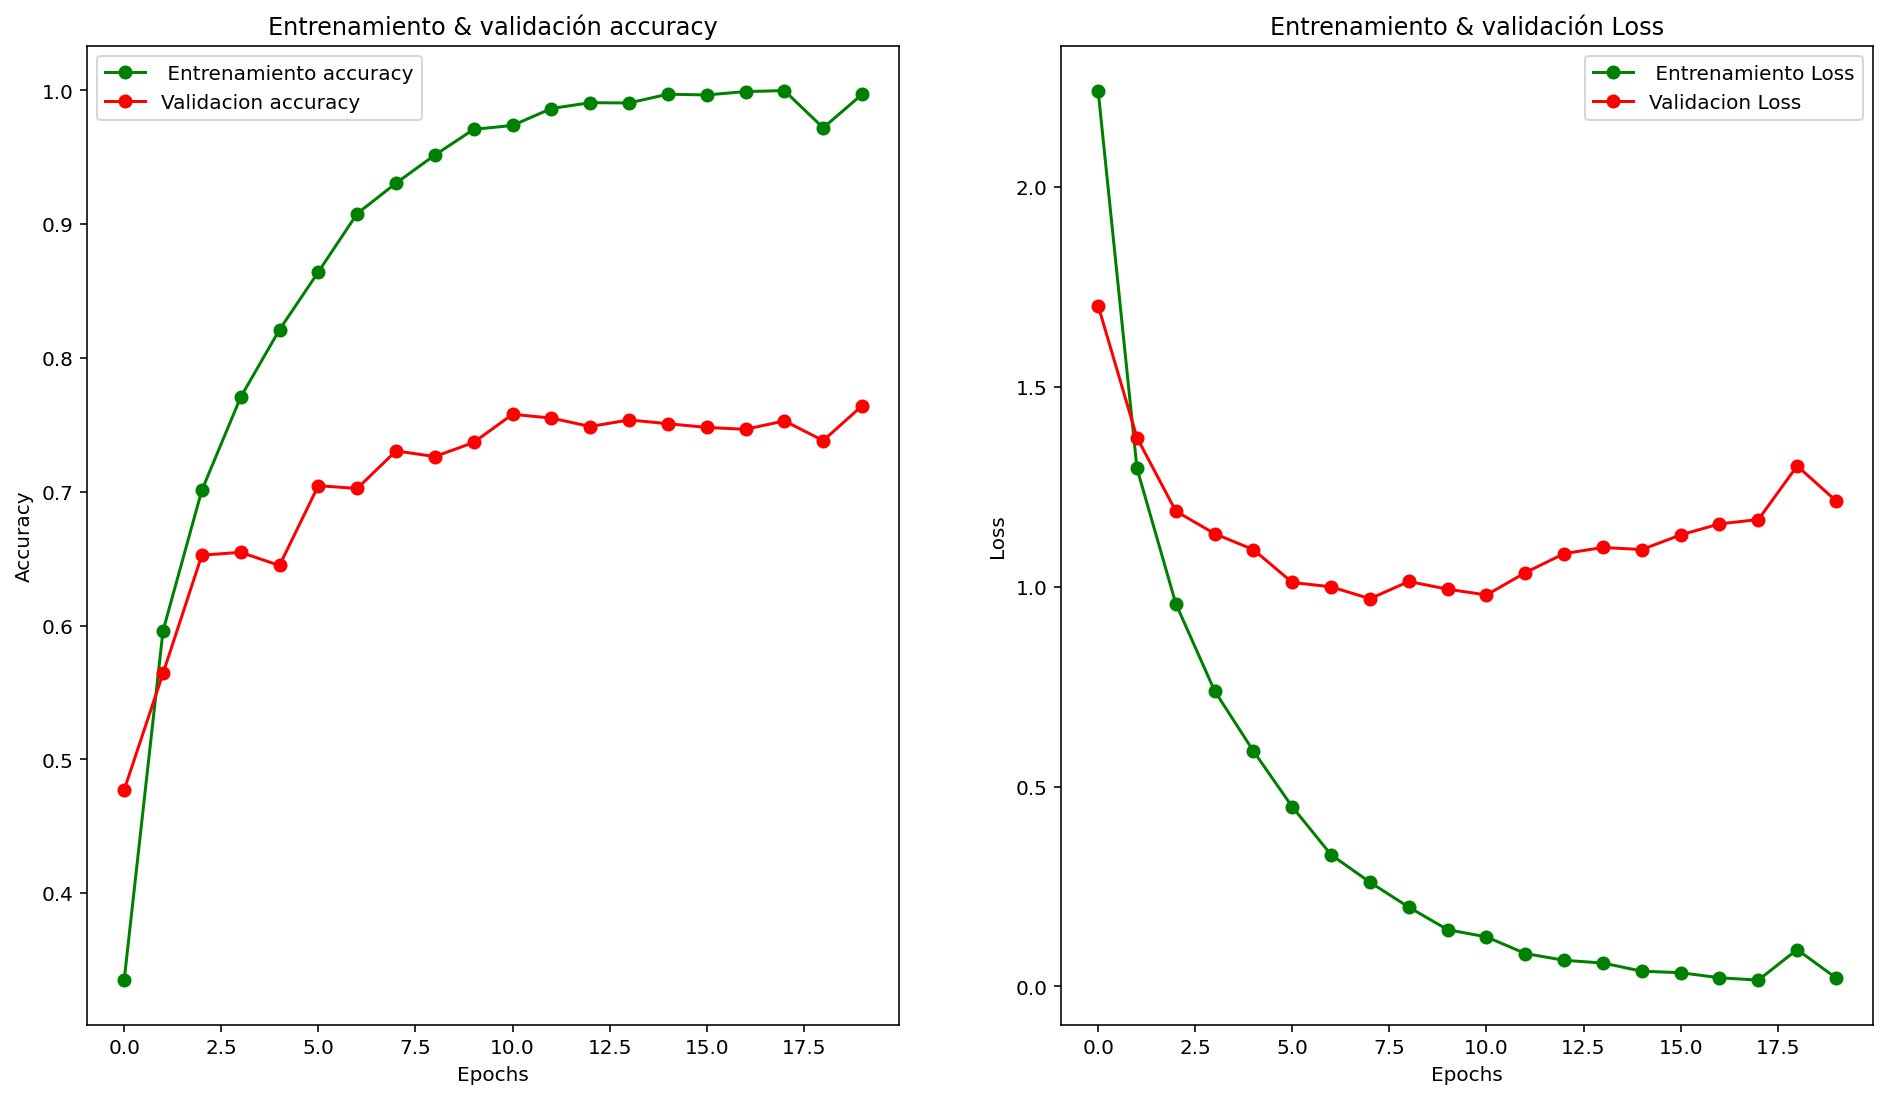

In [11]:
epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(16, 9)

ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
ax[0].plot(epochs, val_acc, "ro-", label= "Validacion accuracy")
ax[0].set_title("Entrenamiento & validación accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
ax[1].plot(epochs, val_loss, "ro-", label= "Validacion Loss")
ax[1].set_title("Entrenamiento & validación Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

___

## IMPROVE BASE MODEL

We'll be using **regularizer** and **droput**

In [12]:
from tensorflow.keras import regularizers

model_optimizer = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape= (28, 28, 1)),
            tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, kernel_regularizer= regularizers.l2(1e-5),activation = "relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(labels), activation = "softmax")
])

model_optimizer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 24)                3096      
                                                                 
Total params: 236,952
Trainable params: 236,952
Non-tr

In [13]:
model_optimizer.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history_optimizer = model_optimizer.fit(
    train_generator,
    epochs = 15,
    validation_data = validation_generator)

Epoch 1/15
215/215 [==============================] - 6s 26ms/step - loss: 2.4392 - accuracy: 0.2509 - val_loss: 1.6578 - val_accuracy: 0.5200
Epoch 2/15
215/215 [==============================] - 6s 26ms/step - loss: 1.4948 - accuracy: 0.5115 - val_loss: 1.3820 - val_accuracy: 0.5691
Epoch 3/15
215/215 [==============================] - 5s 25ms/step - loss: 1.1381 - accuracy: 0.6226 - val_loss: 1.1820 - val_accuracy: 0.6056
Epoch 4/15
215/215 [==============================] - 5s 24ms/step - loss: 0.9430 - accuracy: 0.6849 - val_loss: 0.9969 - val_accuracy: 0.6884
Epoch 5/15
215/215 [==============================] - 5s 25ms/step - loss: 0.7815 - accuracy: 0.7394 - val_loss: 0.9388 - val_accuracy: 0.6968
Epoch 6/15
215/215 [==============================] - 6s 26ms/step - loss: 0.6679 - accuracy: 0.7765 - val_loss: 0.9179 - val_accuracy: 0.7081
Epoch 7/15
215/215 [==============================] - 5s 24ms/step - loss: 0.5793 - accuracy: 0.8090 - val_loss: 0.8486 - val_accuracy: 0.7326

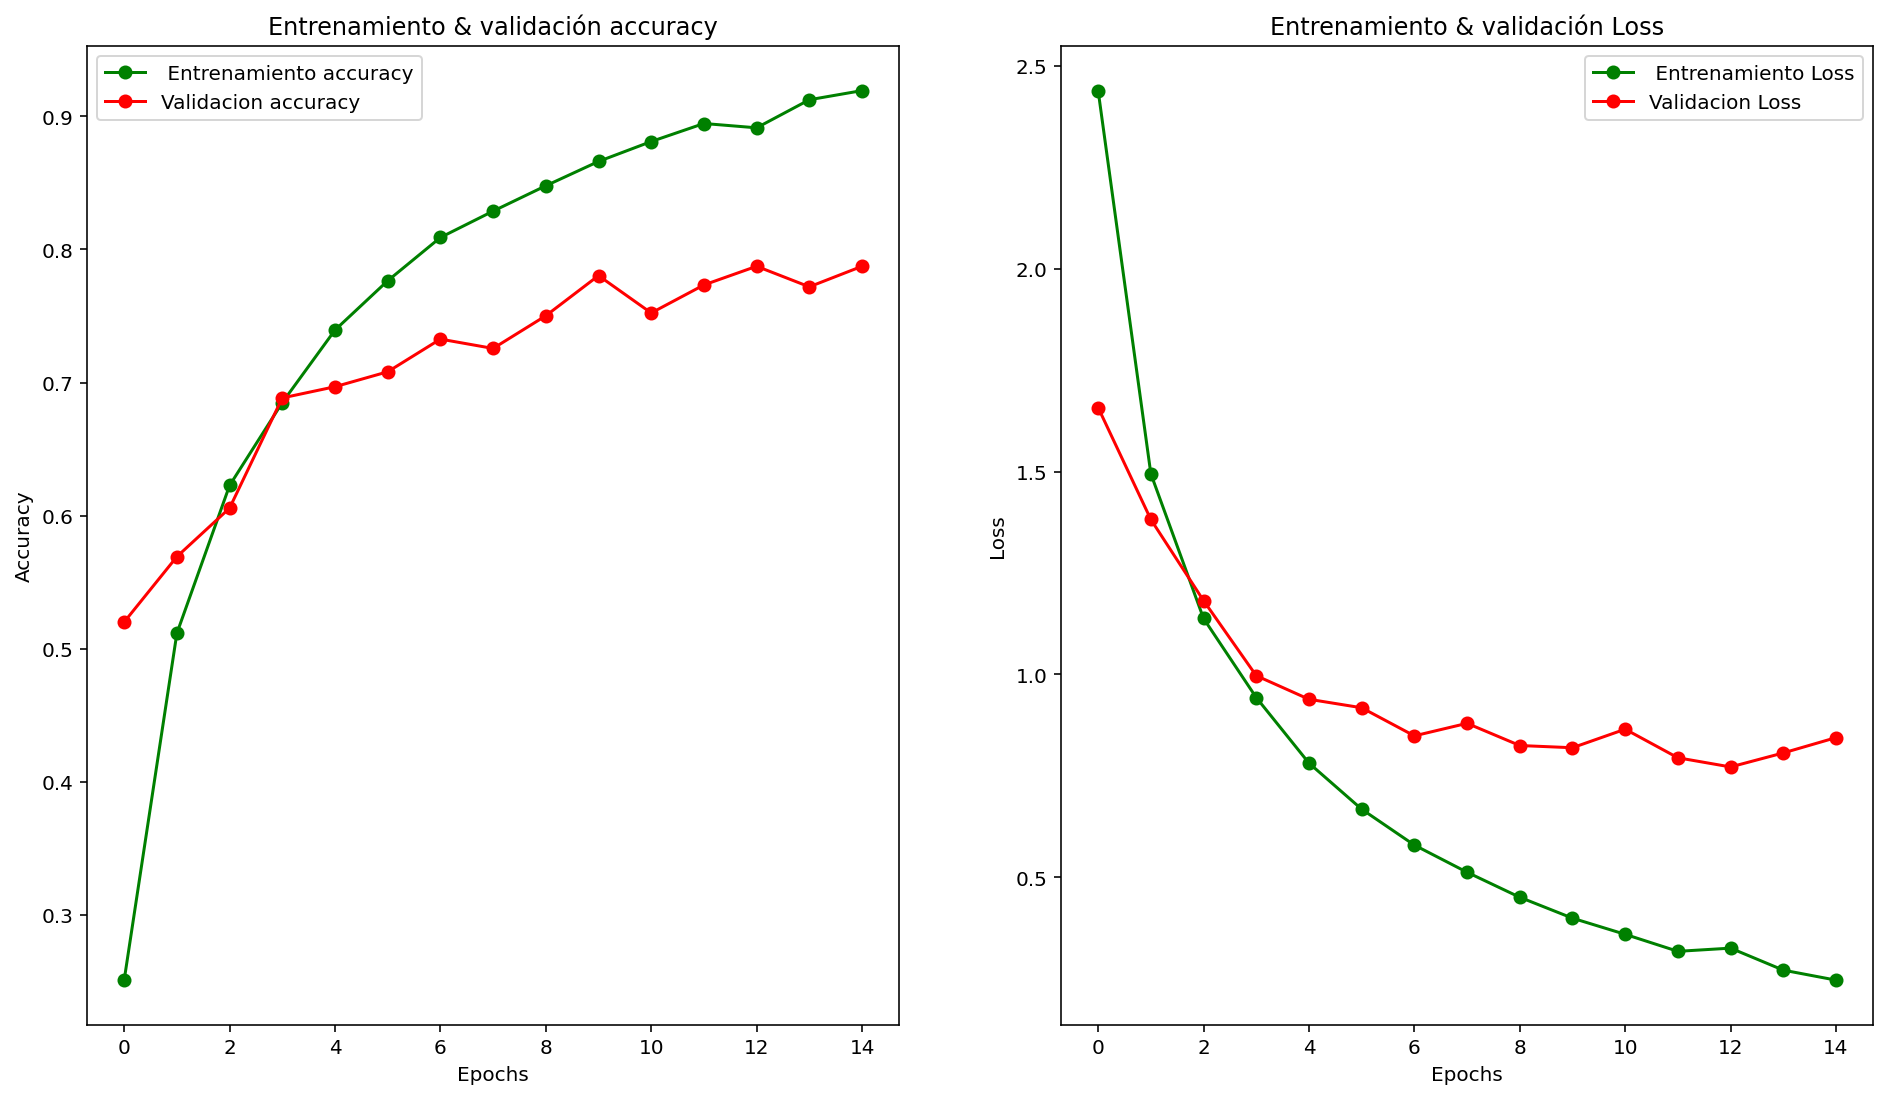

In [14]:
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2)
train_acc = history_optimizer.history["accuracy"]
train_loss = history_optimizer.history["loss"]
val_acc = history_optimizer.history["val_accuracy"]
val_loss = history_optimizer.history["val_loss"]
fig.set_size_inches(16, 9)

ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
ax[0].plot(epochs, val_acc, "ro-", label= "Validacion accuracy")
ax[0].set_title("Entrenamiento & validación accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
ax[1].plot(epochs, val_loss, "ro-", label= "Validacion Loss")
ax[1].set_title("Entrenamiento & validación Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

___

With this simple improvement in less epochs and with a faster training time we get an improvement on accuracy and log loss, still not good enough metrics for a model

Next, we'll be implementing **CNN**